# Análise e extração de features textuais e detecção de similaridade entre projetos culturais

Issues relacionadas:

* [#243](https://github.com/lappis-unb/salic-ml/issues/243): Extração e análise de features textuais dos projetos culturais
* [#245](https://github.com/lappis-unb/salic-ml/issues/245): Detecção de similaridade baseada em features textuais

## Objetivos

Extrair features textuais de projetos culturais do banco de dados do Salic a partir de todos os dados textuais (curtos e longos), como descrição, título, itens, objeto e etc. As features extraídas serão utilizadas para identificação de projetos culturais semelhantes.

---
## Preparação

Nesta etapa serão carregados e explorados os datasets a serem utilizados ao longo de todo o notebook. Serão analisados os datasets de itens orçamentários e o dataset de projetos culturais, ambos serão explorados em busca de features textuais. 

#### Importando módulos e definindo constantes

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors, BallTree, KDTree
from sklearn.metrics import pairwise_distances_argmin

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /usr/share/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Explorando o dataset de itens orçamentários

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026756 entries, 0 to 2026755
Data columns (total 25 columns):
idPronac                int64
PRONAC                  int64
idPlanilhaAprovacao     int64
Item                    object
idPlanilhaItens         int64
Unidade                 object
QtDias                  int64
QtItem                  float64
nrOcorrencia            float64
VlUnitarioSolicitado    float64
VlTotalSolicitado       float64
VlUnitarioAprovado      float64
VlTotalAprovado         float64
UfItem                  object
MunicipioItem           object
Etapa                   object
idArea                  int64
Area                    object
idSegmento              object
Segmento                object
idProduto               int64
Produto                 object
DataProjeto             object
cdCidade                int64
cdEtapa                 int64
dtypes: float64(6), int64(9), object(10)
memory usage: 386.6+ MB


In [3]:
df.head(5).transpose()

,0,1,2,3,4
idPronac,121051,121051,121051,119968,112836
PRONAC,100855,100855,100855,98671,91695
idPlanilhaAprovacao,792860,792883,792903,109095,116511
Item,Passagens Aéreas (Descrever os trechos na tela...,Bonecos – Criação,Produtor executivo,Assistente de produção,Designer
idPlanilhaItens,131,3599,53,1037,103
Unidade,Unidade,Verba,Verba,Verba,Mês
QtDias,150,90,90,30,378
QtItem,40,1,3,1,1
nrOcorrencia,1,1,1,1,18
VlUnitarioSolicitado,150,4000,3000,1000,2000


O primeiro dataset explorado será o de itens orçamentários. Como mostrado acima, tal dataset conta com uma relação de mais de 2 milhões de itens de projetos culturais, desde projetos em fase inicial até projetos já finalizados. Cada item conta com 25 informações, como o identificador do projeto ao qual ele pertence, sua descrição, valor, quantidade e etc.

A seguir, serão explorados os possíveis dados textuais desse dataset, como descrição, unidade, UF, etapa, área e etc.

#### Feature: descrição do item

In [4]:
serie = df['Item'].value_counts()
print(len(serie))
serie.head(10)

3635


Passagens Aéreas (Descrever os trechos na tela de deslocamentos)         38645
Transporte Local / Locação de Automóvel / Combustível                    37290
Refeição                                                                 36904
Assessor de imprensa                                                     33945
Assistente de produção                                                   33106
Remuneração para captação de recursos                                    31393
Produtor executivo                                                       30918
Contador                                                                 30436
Hospedagem sem alimentação                                               28745
Banner/faixa adesiva/faixa de lona/saia de palco/testeira/pórtico\r\n    27832
Name: Item, dtype: int64

#### Feature: unidade de medida do item

In [5]:
serie = df['Unidade'].value_counts()
print(len(serie))
serie

25


Verba                  429350
Serviço                381031
Mês                    334062
Unidade                283488
Dia                    177115
Cachê                  157955
Não Informado          104451
Projeto                 72584
Semana                  27113
Hora                    12174
Metro 2                 11188
Período                  8450
Obra                     6261
Metro                    5147
Folha                    4633
Títulos                  3064
Filme                    2170
Metro 3                  1468
Metro 3 / Km             1196
Instalação                934
Parte                     883
Kilograma                 879
Minuto                    676
Rolo                      365
Kilograma / metro 2       119
Name: Unidade, dtype: int64

#### Feature: UF

In [6]:
serie = df['UfItem'].value_counts()
print(len(serie))
serie.head(10)

27


SP    646819
RJ    451136
MG    247189
RS    141859
PR    109123
BA     74546
SC     73764
DF     56074
PE     47060
CE     41260
Name: UfItem, dtype: int64

#### Feature: município

In [7]:
serie = df['MunicipioItem'].value_counts()
print(len(serie))
serie.head(10)

2624


São Paulo         522997
Rio de Janeiro    414688
Belo Horizonte    140287
Curitiba           69196
Porto Alegre       67139
Salvador           61704
Brasília           56074
Recife             36803
Fortaleza          34467
Florianópolis      31204
Name: MunicipioItem, dtype: int64

#### Feature: etapa do projeto na qual o item foi utilizado

In [8]:
serie = df['Etapa'].value_counts()
print(len(serie))
serie

10


2 - Produção / Execução               1195315
3 - Divulgação / Comercialização       315280
1 - Pré-Produção / Preparação          254998
4 - Custos / Administrativos           224104
5 - Recolhimentos                       28290
8 - Custos Vinculados                    4546
9 - Assessoria Contábil e Juridica       3284
7 - Pós-Produção                          444
10 - Captação de Recursos                 273
6 - Elaboração e Agenciamento             222
Name: Etapa, dtype: int64

#### Feature: área de atuação do projeto cultural no qual o item foi cadastrado

In [9]:
serie = df['Area'].value_counts()
print(len(serie))
serie.head(10)

8


Artes Cênicas          692268
Música                 538580
Audiovisual            223751
Humanidades            220100
Artes Visuais          209203
Patrimônio Cultural     96197
Artes Integradas        46119
Museus e Memória          538
Name: Area, dtype: int64

#### Feature: segmento do projeto cultural no qual o item foi cadastrado

In [10]:
serie = df['Segmento'].value_counts()
print(len(serie))
serie.head(10)

124


Teatro                                                535070
Música Popular Cantada                                232959
Música Instrumental                                   194252
Exposição de Artes Visuais                            156503
Dança                                                 104788
Música Erudita                                         96453
Difusão de acervo audiovisual                          87437
Artes Integradas                                       56222
Livros  ou obras de referência - valor Artístico       53404
Livros ou  obras de referência - valor Humanístico     50906
Name: Segmento, dtype: int64

#### Feature: produto cultural no qual o item foi utilizado

In [11]:
serie = df['Produto'].value_counts()
print(len(serie))
serie.head(10)

75


Espetáculo de Artes Cênicas                458157
Apresentação Musical                       268370
Administracao do Projeto                   256570
Festival/Mostra                            207151
Exposição de Artes                         142098
Livro                                      114703
Festival/Mostra - Audiovisual               78713
Curso / Oficina / Estágio                   54920
DVD                                         46570
Oficina /Workshop/Seminário Audiovisual     40385
Name: Produto, dtype: int64

Na análise das features textuais acima, foi possível identificar características de itens e projetos culturais, como:

1. Transporte, alimentação e acessoria de imprensa são os itens mais utilizados em projetos culturais, dentre as 3635 opções já utilizadas;
1. Dentre 25 categorias, verba, serviço, mês e unidade são as principais unidades de medida dos itens;
1. Mais de 60% dos itens estão cadastrados na região sudeste, sendo São Paulo o estado com a maior quantidade de itens cadastrados;
1. Todos os 10 municípios com mais itens de projetos culturais cadastrados são capitais de estados brasileiros;
1. Mais da metade dos itens são utilizados na etapa de produção/execução de projetos culturais, as próximas etapas que mais concentram os itens são divulgação, pré-produção e custos administrativos;
1. Entre 8 áreas possíveis, a maior parte dos itens têm seus projetos classificados nas áreas de artes cênicas ou música;
1. Além disso, a maior parte dos itens têm seus projetos concentrados nos segmentos de teatro, música popular cantada, música instrumental, exposição de artes visuais e dança, sendo 124 o número total de segmentos;
1. Os produtos culturais mais frequentes nos itens são os de espetáculo de artes cênicas, apresentação musical e administração do projeto, em um universo de 75 produtos distintos.

A maior parte das features analisadas referem-se unicamente aos itens, não sendo relevantes na detecção de projetos similares a um projeto específico, por isso, o dataset analisado acima será pouco utilizado.

Abaixo será explorado o dataset de projetos culturais, com várias características associadas a projetos culturais em si, nãos apenas aos seus itens orçamentários.

### Explorando o dataset de projetos culturais

In [12]:
df = pd.read_csv('../../data/raw/planilha_projetos_luciano.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210684 entries, 0 to 210683
Data columns (total 35 columns):
PRONAC                   210684 non-null object
IdPRONAC                 210684 non-null int64
AnoProjeto               210684 non-null object
Sequencial               210684 non-null object
UfProjeto                210684 non-null object
Area                     210684 non-null int64
Segmento                 210684 non-null object
Mecanismo                210684 non-null int64
NomeProjeto              210675 non-null object
Processo                 210684 non-null object
CgcCpf                   210684 non-null object
Situacao                 210684 non-null object
DtProtocolo              210684 non-null object
DtAnalise                210684 non-null object
Modalidade               185255 non-null object
OrgaoOrigem              210684 non-null int64
Orgao                    210684 non-null int64
DtSaida                  74704 non-null object
DtRetorno                80159 

In [13]:
df.head().transpose()

,0,1,2,3,4
PRONAC,087079,087080,087081,087082,087083
IdPRONAC,1,2,3,4,5
AnoProjeto,08,08,08,08,08
Sequencial,7079,7080,7081,7082,7083
UfProjeto,SP,SP,ES,RJ,SP
Area,7,3,3,4,1
Segmento,71,31,31,47,11
Mecanismo,1,2,2,1,1
NomeProjeto,"São Paulo; O que foi, O que era e o que é",Festival BrasilNoar 2008 – 8° Festival Interna...,Festival BrasilNoar 2008 – 8° Festival Interna...,"Exposição "" Eliseu Visconti - Retrospectiva""",Príncipe Feliz (O)
Processo,015450009710821,014000064890849,014000064900873,014000062310842,015450009720875


O segundo dataset explorado descreve os projetos culturais. Como mostrado acima, tal dataset conta com uma relação de mais de 210 mil projetos culturais e cada projeto tem 35 informações, como datas de íncio e fim de execução, ano, UF, identificador, situação e etc.

A seguir, serão removidos projetos inconsistentes e os projetos que ainda não chegaram à fase de análise de resultados, pois, neste estudo, o intuito é analisar e detectar similaridade entre projetos já executados. Então, serão explorados os possíveis dados textuais desse dataset, como nome, resumo, segmento, órgão, área, UF e etc.

#### Remoção de projetos inconsistentes

In [14]:
inconsistent_pronacs = pd.to_numeric(df['PRONAC'], errors='coerce').isnull()
df[ inconsistent_pronacs ]

,PRONAC,IdPRONAC,AnoProjeto,Sequencial,UfProjeto,Area,Segmento,Mecanismo,NomeProjeto,Processo,...,DtInicioExecucao,DtFimExecucao,SolicitadoUfir,SolicitadoReal,SolicitadoCusteioUfir,SolicitadoCusteioReal,SolicitadoCapitalUfir,SolicitadoCapitalReal,Logon,idProjeto
105918,XXXXXX,105919,XX,XXXX,DF,1,11,1,Projeto especial,X,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Antes de analisar as features textuais, analisou-se a coluna PRONAC (identificador único do projeto) e verificou-se a existência de um único PRONAC inválido (não numérico). Tal projeto será removido, pois é provavelmente um resquício do banco de dados de homologação e não tem informações válidas.

In [15]:
df = df[~inconsistent_pronacs]

In [16]:
df['PRONAC'].describe()

count     210683
unique    210683
top       132172
freq           1
Name: PRONAC, dtype: object

#### Remoção de projetos ainda não executados

O primeiro passo é a remoção de projetos sem data de fim de execução, então serão removidos os projetos com data de fim de execução após o ano de 2018 e, por fim, a coluna 'DtFimExecucao' será traduzida para o tipo 'datetime'.

In [17]:
df.dropna(subset=['DtFimExecucao'], inplace=True)
df['DtFimExecucao'].describe()

count                   76933
unique                  13079
top       2018-12-31 00:00:00
freq                     4252
Name: DtFimExecucao, dtype: object

In [18]:
df = df[ df['DtFimExecucao'].apply(lambda x: int(x[0:4]) <= 2018) ]
df['DtFimExecucao'].describe()

count                   75237
unique                  11500
top       2018-12-31 00:00:00
freq                     4252
Name: DtFimExecucao, dtype: object

In [19]:
df['DtFimExecucao'] = pd.to_datetime(df['DtFimExecucao'])
df['DtFimExecucao'].describe()

count                   75237
unique                  11500
top       2018-12-31 00:00:00
freq                     4252
first     1900-01-01 00:00:00
last      2018-12-31 23:58:49
Name: DtFimExecucao, dtype: object

In [20]:
df = df[ df['DtFimExecucao'].apply(lambda x: x.year < 2018 or x.month < 10) ]
df['DtFimExecucao'].describe()

count                   69578
unique                  10265
top       2013-12-31 00:00:00
freq                     3673
first     1900-01-01 00:00:00
last      2018-09-30 23:47:43
Name: DtFimExecucao, dtype: object

In [21]:
df = df[ df['DtFimExecucao'].apply(lambda x: x.year >= 1992) ]
df['DtFimExecucao'].describe()

count                   69569
unique                  10259
top       2013-12-31 00:00:00
freq                     3673
first     1994-09-15 00:00:00
last      2018-09-30 23:47:43
Name: DtFimExecucao, dtype: object

#### Feature: UF dos projetos

In [22]:
serie = df['UfProjeto'].value_counts()
print(len(serie))
serie.head(10)

27


SP    21088
RJ    15267
MG     7840
RS     5169
PR     4508
SC     3034
BA     2454
DF     2082
PE     1381
CE     1359
Name: UfProjeto, dtype: int64

#### Feature: nome dos projetos

In [23]:
serie = df['NomeProjeto'].value_counts()
print(len(serie))
serie = serie[ serie > 1 ]
print(len(serie))
serie.head(10)

67122
1587


Implantação de biblioteca pública       101
Casa da Cultura                          58
Modernização de Acervo Bibliográfico     46
Implantaçào de Biblioteca Pública        46
Bolsa Virtuose                           44
CONSTRUÇÃO DE CENTRO CULTURAL            30
Implantação de biblioteca pública.       26
Implantação de Biblioteca Pública        23
CASA DA CULTURA                          21
Construção de Centro Cultural            16
Name: NomeProjeto, dtype: int64

Cerca de 3.5% dos projetos têm nomes que não são únicos, sendo "Implantação de Biblioteca Pública" o nome mais comum entre os projetos culturais.

Abaixo é apresentada uma nuvem de palavras com as palavras e colocações (bigramas) mais frequentes nos nomes de projetos culturais. Em uma nuvem de palavras, quanto maiores as palavras, mais frequentes elas são.

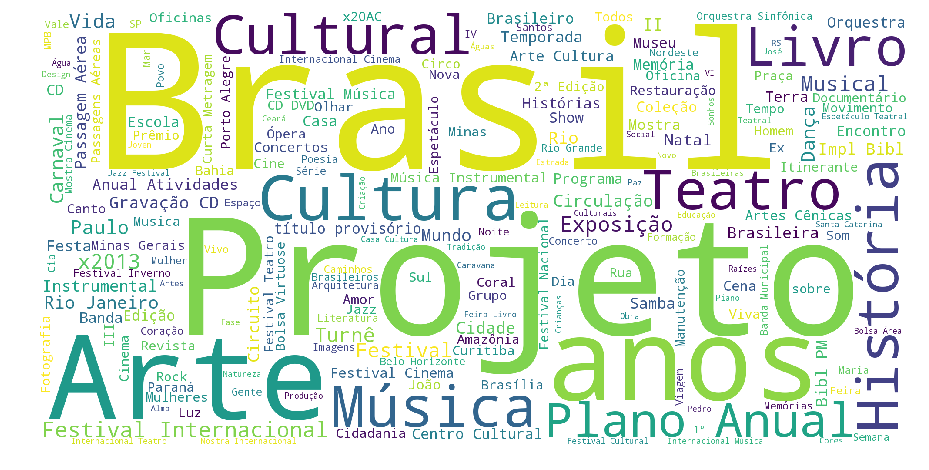

In [24]:
corpus = ' '.join(df['NomeProjeto'].astype('str').unique())

img = WordCloud(
    background_color='white',
    stopwords=stopwords.words('portuguese'),
    height=1000,
    width=2000,
    normalize_plurals=False
).generate(corpus)

plt.figure(figsize(16,8))
plt.imshow(img)
plt.axis('off');

#### Feature: situação atual dos projetos

In [25]:
serie = df['Situacao'].value_counts()
print(len(serie))
serie.head(10)

159


K00    13324
E63    12637
E24     8729
E65     4755
E19     3230
E16     2946
A17     2573
E68     2441
E36     2357
A42     2050
Name: Situacao, dtype: int64

#### Feature: unidade/local de análise dos projetos

In [26]:
serie = df['UnidadeAnalise'].value_counts()
print(len(serie))
serie.head(10)

36


               57630
FUNARTE         3647
SAC/Ad hoc      3314
FBN             1491
SDAV             821
IPHAN            623
SEXEC            316
CAP              226
FUNARTE/BSB      217
COGMEC           168
Name: UnidadeAnalise, dtype: int64

#### Feature: analista responsável pelo projeto

In [27]:
serie = df['Analista'].value_counts()
print(len(serie))
serie.head(10)

447


                            50100
Eunice Linhares Reis         2315
Napoleão Alvarenga Filho     1534
Napoleão                      882
Edmo                          798
Emília Gomes Fernandes        745
Tânia Regina Boita            694
Pablo Araújo Assunção         552
Francisco Assis Coelho        552
James                         442
Name: Analista, dtype: int64

#### Feature: resumo do projeto

In [28]:
serie = df['ResumoProjeto'].value_counts()
print(len(serie))
serie = serie[ serie > 1 ]
print(len(serie))
serie.head(10)

68680
375


Acervo                                                                                                                                                    125
Editar um livro                                                                                                                                            50
Implantaçào de Biblioteca Pública                                                                                                                          35
Projeto Aprovado em Concurso Roteiro/1999                                                                                                                  32
Implantação de biblioteca pública                                                                                                                          29
Implantação de biblioteca pública.                                                                                                                         27
Construção de Centro Cultural                       

Alguns projetos têm resumos idênticos, cerca de 1.3% dos projetos têm resumos que não são únicos, sendo "Acervo" o resumo mais comum de projetos culturais, presente em 125 projetos distintos.

Abaixo é apresentada uma nuvem de palavras com as palavras e colocações mais frequentes nos resumos de projetos culturais.

In [29]:
import html
df['ResumoProjeto_utf-8'] = df['ResumoProjeto'].apply(lambda x: html.unescape(x))

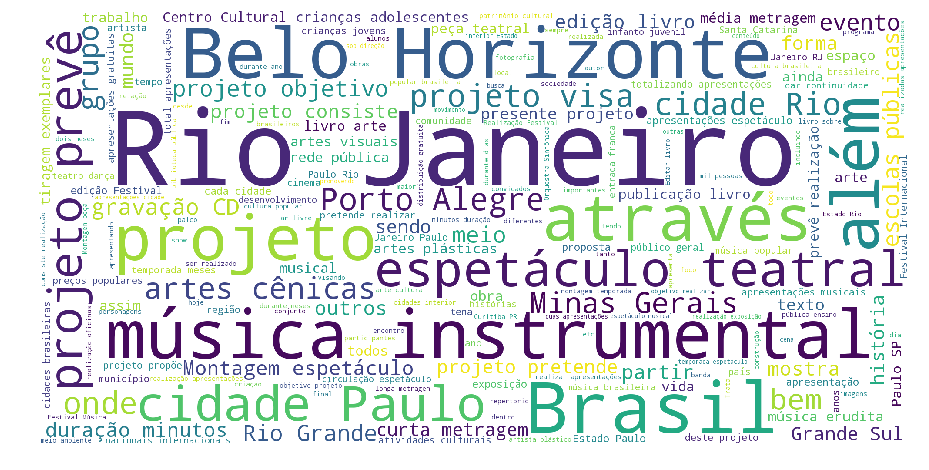

In [30]:
corpus = ' '.join(df['ResumoProjeto_utf-8'].astype('str').unique())

img = WordCloud(
    background_color='white',
    stopwords=stopwords.words('portuguese'),
    height=1000,
    width=2000,
    normalize_plurals=False
).generate(corpus)

plt.figure(figsize(16,8))
plt.imshow(img)
plt.axis('off');

#### Feature: providência tomada

In [31]:
serie = df['ProvidenciaTomada'].value_counts()
print(len(serie))
serie.head(10)

25251


Nada captou - projeto arquivado                                                                                                                                                                                                                                                                                                4625
Projeto arquivado definitivamente, tendo  em vista encerramento do prazo de 24 meses sem captação.                                                                                                                                                                                                                             3455
PRAZO DE CAPTAÇÃO DE RECURSOS ENCERRADO.                                                                                                                                                                                                                                                                                       2751
Projeto ARQUIVADO, conforme 

#### Feature: localização do projeto (entre os órgãos do governo)

In [32]:
serie = df['Localizacao'].value_counts()
print(len(serie))
serie.head(10)

4201


                 58353
DCA               1038
SAV/CEP            721
SPOA/DCA           582
SSD                358
SEFIC/CGAA         335
DCA/SPOA           235
ARQUIVO GERAL      196
SSD/SPOA           180
SSD/ARQUIVO        131
Name: Localizacao, dtype: int64

Na análise das features textuais acima, foi possível identificar diversas características de projetos culturais, como:

1. Todos os PRONACs são de fato únicos e númericos;
1. Mais da metade dos projetos são iniciativas da região sudeste, sendo São Paulo o estado com a maior quantidade de projetos culturais;
1. Muitos projetos têm nomes repetidos e as palavras Brasil, Projeto e Arte estão entre as mais utilizadas nos nomes de projetos;
1. Mais da metade dos projetos estão em uma das quatro situações: K00, E63, E24 ou E65. Sendo K00 a situação na qual mais projetos se encontram;
1. 81% dos projetos não estão vinculados a nenhuma unidade de análise, do restante, a unidade que mais têm projetos vinculados é a FUNARTE;
1. Mais de 70% dos projetos não estão vinculados a nenhum analista. O restante está distribuído entre 446 analistas, contudo, parte desses analistas são fictícios, com nomes como "q", "xx", "VAL", "Não Consta" e etc;
1. Alguns projeto têm também resumos repetidos. Dentre as palavras mais utilizadas em resumos estão nomes de capitais de estados brasileiros;
1. A principals providência tomada, no conjunto de projetos cuja data de execução já finalizou, é a de arquivar o projeto por falta de captação, contudo, várias providências podem ser tomadas ao longo de um projeto, a apresentada deve ser apenas a última providência tomada no projeto;
1. Quase 85% dos projetos não tem localização definida, tornando essa feature não muito útil. Do restante, as localizações mais frequentes são: DCA, SAV/CEP, SPOA/DCA, SSD e SEFIC/CGAA.

Além disso, após a remoção de projetos ainda não finalizados ou sem data de finalização definida, o número de projetos caiu de 210 mil para 70 mil.

---
## Desenvolvimento

Nesta seção, serão apresentadas diversas estratégias para ranquear os projetos mais similares a um projeto cultural específico.

### Primeiro modelo: bag-of-words dos nomes dos projetos sem tratamento

O primeiro modelo de identificação de projetos similares vai levar em consideração apenas o nome dos projetos, ou seja, dado um PRONAC específico, será gerado um rank dos projetos com os nomes mais parecidos com aquele.

Será utilizada a técnica de BOW (_Bag of Words_), criando-se um vetor de frequências das palavras, onde as palavras mais frequentes serão selecionadas como features. Por fim, será criado, treinado e testado o modelo de detecção de similaridade, utilizando o algoritmo KNN (_K Nearest Neighbors_).

#### Extração do nome dos projetos

In [33]:
projects = df[['PRONAC', 'NomeProjeto']].copy()
projects.rename(inplace=True, columns={
    'NomeProjeto': 'name',
    'PRONAC': 'id'
})
projects.set_index('id', inplace=True)
projects['name'] = projects['name'].astype('str')
projects.head()

,name
id,
087079,"São Paulo; O que foi, O que era e o que é"
087088,Espaço Cultural FGV
087413,Revitalização do Teatro Redenção
087262,Cinema Itinerante Continuação
029740,Brasil Passado a Sujo


#### Criação da "Bag of Words"

In [34]:
data = projects['name'].values
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Utilizando o algoritmo KNN para encontrar os projetos mais similares a um projeto específico

In [35]:
pronacs = projects.index.values
def neighbors(pronac, n_neighbors=10):
    i = 0
    while pronacs[i] != pronac:
        i += 1
        if i == len(pronacs):
            raise ValueError('PRONAC "{}" not found.'.format(pronac))
    
    print('Projeto base:')
    display(df.iloc[i:i+1][['PRONAC', 'NomeProjeto']])
    
    print()
    print('Top projetos similares:')
    nbrs_bf = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean').fit(X)
    d, indices = nbrs_bf.kneighbors([X[i]])
    display(df.iloc[indices[0]][['PRONAC', 'NomeProjeto']])

#### Testando o detector de similaridade

In [36]:
neighbors('128276')

Projeto base:


,PRONAC,NomeProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...



Top projetos similares:


,PRONAC,NomeProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...
156102,128313,Plano Anual de Atividades 2013 - Itaú Cultural
154625,126836,Plano Anual de Atividades Osesp 2013
156959,129170,Plano Anual de Atividades 2013
155881,128092,Plano Anual de Atividades 2013
156223,128434,Plano Anual de Atividades Poiesis 2013
156105,128316,Plano Anual de Atividades 2013
155143,127354,Plano Anual de Atividades 2013
156336,128547,Plano Anual de atividades Videobrasil (2013)
155858,128069,Plano Anual de Atividades 2013 - Fundação Cult...


In [37]:
neighbors('087079')

Projeto base:


,PRONAC,NomeProjeto
0,087079,"São Paulo; O que foi, O que era e o que é"



Top projetos similares:


,PRONAC,NomeProjeto
0,087079,"São Paulo; O que foi, O que era e o que é"
178333,148617,O que seria que fosse?
134432,111595,O que será que virá?
11140,014727,Jean Que Ri & Jean Que Chora
197677,162254,"Documentários que informam, documentos que formam"
132885,110048,Pet e Refri Que maravilha que é o Mar
115582,094494,O MUNDO QUE VEMOS E QUE VIVEMOS
162702,134539,O que você gostaria que ficasse
16713,021231,Agora é que São Elas
161717,133554,POR QUE SERÁ QUE AS AMAMOS TANTO?


### Segundo modelo: bag-of-words dos nomes dos projetos com pré-processamento de dados

O segundo modelo de identificação de projetos similares também vai levar em consideração apenas o nome dos projetos, ou seja, dado um PRONAC específico, será gerado um rank dos projetos com os nomes mais parecidos com aquele.

Para começar, serão extraídos apenas o identificador (PRONAC) e o nome dos projetos culturais. Em seguida, serão realizadas as seguintes etapas de pré-processamento:

1. Remoção de caracteres não alfanuméricos;
1. Passagem de todos os nomes para minúsculos;
1. Identificação de colocações (bigramas);
1. Segmentação dos nomes (tokenize);
1. Remoção de palavras vazias (stopwords);
1. Redução das palavras flexionadas à sua base ou raiz (stemming).

Após todas as etapas de pré-processamento, será utilizada a técnica de "Bag of Words" da mesma forma que o primeiro modelo.

#### Extração do nome dos projetos

In [38]:
projects = df[['PRONAC', 'NomeProjeto']].copy()
projects.rename(inplace=True, columns={
    'NomeProjeto': 'name',
    'PRONAC': 'id'
})
projects.set_index('id', inplace=True)
projects['name'] = projects['name'].astype('str')
projects.head()

,name
id,
087079,"São Paulo; O que foi, O que era e o que é"
087088,Espaço Cultural FGV
087413,Revitalização do Teatro Redenção
087262,Cinema Itinerante Continuação
029740,Brasil Passado a Sujo


#### Remoção de caracteres não-alfanuméricos

In [39]:
rm_special_chars = lambda x: re.sub('[^\w]', ' ', x)

projects['name'] = projects['name'].apply(rm_special_chars)
projects.head()

,name
id,
087079,São Paulo O que foi O que era e o que é
087088,Espaço Cultural FGV
087413,Revitalização do Teatro Redenção
087262,Cinema Itinerante Continuação
029740,Brasil Passado a Sujo


#### Tranformação de todos os caracteres para minúsculo

In [40]:
to_lower = lambda x: x.lower()

projects['name'] = projects['name'].apply(to_lower)
projects.head()

,name
id,
087079,são paulo o que foi o que era e o que é
087088,espaço cultural fgv
087413,revitalização do teatro redenção
087262,cinema itinerante continuação
029740,brasil passado a sujo


#### Identificação de colocações

Antes de realizar a segmentação do texto, encontrou-se as colocações mais comuns. Desta forma, ao segmentar o texto, colocações muito comuns são tratadas como uma única palavra.

In [41]:
def get_collocations(serie, n_collocations=500):
    x = ' '.join(serie.values).split()

    stop_words = stopwords.words('portuguese')
    bigrams = nltk.bigrams([w for w in x if  w == 'são' or w not in stop_words])

    collocations = nltk.FreqDist(bigrams).most_common(n_collocations)
    return list(map(lambda x: x[0], collocations))

collocations = get_collocations(projects['name'])
collocations[:10]

[('plano', 'anual'),
 ('festival', 'internacional'),
 ('são', 'paulo'),
 ('rio', 'janeiro'),
 ('gravação', 'cd'),
 ('passagem', 'aérea'),
 ('impl', 'bibl'),
 ('bibl', 'pm'),
 ('centro', 'cultural'),
 ('anual', 'atividades')]

#### Segmentação dos nomes

In [42]:
def tokenize(x):
    words = x.split()
    tokens = []
    
    is_token = False
    for i in range(len(words)):
        if is_token:
            is_token = False
        elif i+1 == len(words):
            tokens.append(words[i])
        elif (words[i], words[i+1]) in collocations:
            tokens.append('{}_{}'.format(words[i], words[i+1]))
            is_token = True
        elif words[i] != 'são':
            tokens.append(words[i])
    
    return tokens

projects['name'] = projects['name'].apply(tokenize)
projects.head()

,name
id,
087079,"[são_paulo, o, que, foi, o, que, era, e, o, qu..."
087088,"[espaço_cultural, fgv]"
087413,"[revitalização, do, teatro, redenção]"
087262,"[cinema_itinerante, continuação]"
029740,"[brasil, passado, a, sujo]"


#### Remoção de palavras vazias

In [43]:
stop_words = stopwords.words('portuguese')
rm_stopwords = lambda x: [w for w in x if w not in stop_words]

projects['name'] = projects['name'].apply(rm_stopwords)
projects.head()

,name
id,
087079,"[são_paulo, é]"
087088,"[espaço_cultural, fgv]"
087413,"[revitalização, teatro, redenção]"
087262,"[cinema_itinerante, continuação]"
029740,"[brasil, passado, sujo]"


#### Redução de palavras flexionadas

In [44]:
stemmer = RSLPStemmer()
stem = lambda x: [stemmer.stem(w) for w in x]

projects['name'] = projects['name'].apply(stem)
projects.head()

,name
id,
087079,"[são_paul, é]"
087088,"[espaço_cult, fgv]"
087413,"[revit, teatr, redenç]"
087262,"[cinema_itiner, continu]"
029740,"[brasil, pass, suj]"


#### Criação da "Bag of Words"

In [45]:
data = projects['name'].apply(lambda x: ' '.join(x)).values
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Testando o detector de similaridade

In [46]:
neighbors('128276')

Projeto base:


,PRONAC,NomeProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...



Top projetos similares:


,PRONAC,NomeProjeto
155915,128126,Plano Anual de Atividades Cultura 2013
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...
156102,128313,Plano Anual de Atividades 2013 - Itaú Cultural
156223,128434,Plano Anual de Atividades Poiesis 2013
120054,100077,Plano Anual de Atividades Cultura 2010-2011
154625,126836,Plano Anual de Atividades Osesp 2013
155652,127863,Plano Anual de Atividades Santa Marcelina Cult...
155143,127354,Plano Anual de Atividades 2013
156959,129170,Plano Anual de Atividades 2013
155881,128092,Plano Anual de Atividades 2013


In [47]:
neighbors('087079')

Projeto base:


,PRONAC,NomeProjeto
0,087079,"São Paulo; O que foi, O que era e o que é"



Top projetos similares:


,PRONAC,NomeProjeto
158547,130384,Guri de uruguaiana em São Paulo
155775,127986,Idea City São Paulo
186496,152350,Colecão São Paulo
158172,130009,Projeções Espetaculares Centro Histórico de Sã...
158608,130445,"São Paulo - O que você enxerga, mas não vê."
142655,119825,SÃO PAULO - MOSTRA ARTE
113406,092318,IMPROVÁVEL EM SÃO PAULO
197514,162091,São Paulo Vertical
38638,046993,Bondes de São Paulo
112434,091346,ABOUT US - SÃO PAULO


### Terceiro modelo: bag-of-words dos nomes e resumos dos projetos

O terceiro modelo de identificação de projetos similares vai levar em consideração o nome e o resumo de cada projeto. Após as etapas de pré-processamento, será utilizada a técnica de "Bag of Words" da mesma forma que os primeiro e segundo modelos.

#### Extração do nome e resumo dos projetos

In [48]:
projects = df[['PRONAC', 'NomeProjeto', 'ResumoProjeto']].copy()
projects.rename(inplace=True, columns={
    'PRONAC': 'id',
    'NomeProjeto': 'name',
    'ResumoProjeto': 'abstract'
})
projects.set_index('id', inplace=True)
projects['name'] = projects['name'].astype('str')
projects['abstract'] = projects['abstract'].astype('str')
projects.head()

,name,abstract
id,,
087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."
087088,Espaço Cultural FGV,"Visa instalar um espaço cultural, afim de adeq..."
087413,Revitalização do Teatro Redenção,Executar as obras de restauração e adaptação p...
087262,Cinema Itinerante Continuação,Realização de exibição itinerante de filmes br...
029740,Brasil Passado a Sujo,Realizar na Praça do Espaço Cultural dos Corre...


#### Criação da "Bag of Words"

In [49]:
data = projects['name'].values
matrix_name = CountVectorizer(max_features=500)
X_name = matrix_name.fit_transform(data).toarray()

data = projects['abstract'].values
matrix_abstract = CountVectorizer(max_features=500)
X_abstract = matrix_abstract.fit_transform(data).toarray()

X = np.hstack([X_name, X_abstract])
print(X.shape)
X

(69569, 1000)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Utilizando o algoritmo KNN para encontrar os projetos mais similares a um projeto específico

In [50]:
pronacs = projects.index.values
def neighbors(pronac, n_neighbors=10):
    i = 0
    while pronacs[i] != pronac:
        i += 1
        if i == len(pronacs):
            raise ValueError('PRONAC "{}" not found.'.format(pronac))
    
    print('Projeto base:')
    display(df.iloc[i:i+1][['PRONAC', 'NomeProjeto', 'ResumoProjeto']])
    
    print()
    print('Top projetos similares:')
    nbrs_bf = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean').fit(X)
    d, indices = nbrs_bf.kneighbors([X[i]])
    display(df.iloc[indices[0]][['PRONAC', 'NomeProjeto', 'ResumoProjeto']])

#### Testando o detector de similaridade

In [51]:
neighbors('128276')

Projeto base:


,PRONAC,NomeProjeto,ResumoProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...,O projeto Santander Cultural - 2013 - Plano An...



Top projetos similares:


,PRONAC,NomeProjeto,ResumoProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...,O projeto Santander Cultural - 2013 - Plano An...
155143,127354,Plano Anual de Atividades 2013,O projeto visa à manutenção do Instituto Vladi...
169062,1310899,Plano Anual de Atividades 2014,Planejamento de custeio das atividades e insum...
180338,1410622,Plano Anual de Atividades e Manutenção 2015 - ...,Plano Anual de Atividades e Manutenção do NAC ...
167469,139306,Plano Anual de Atividades e Manutenção 2014 - ...,Plano Anual de Atividades e Manutenção do NAC ...
109289,089376,Centro Cultural De Nhumirim,O objetivo principal a restauração da antiga E...
156777,128988,Plano Anual de Atividades 2013 do Parque Histó...,Planejamento de custeio das atividades e insum...
160099,131936,DVD Francis Lopes,Vamos gravar um DVD de Forró e músicas de Embo...
166491,138328,Plano Anual de Atividades 2014 - Museu Lasar S...,O projeto tem o objetivo de contemplar a manut...
133374,110537,Teatro e Centro Cultural Águas de Lindóia,O projeto “Teatro e Centro Cultural Águas de L...


In [52]:
neighbors('087079')

Projeto base:


,PRONAC,NomeProjeto,ResumoProjeto
0,087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."



Top projetos similares:


,PRONAC,NomeProjeto,ResumoProjeto
0,087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."
23860,029127,Bagagem A Estória Que Cada Um Guarda,"Realização de uma série de 30 programas, com 2..."
84739,971994,Mas Que Reino É Esse?,Realização de montagem de comédia político-sar...
182935,1413219,SOCIALITES,"Produção, montagem e temporada inicial de doze..."
77654,086993,Projeto Midiateca,"Catalogação, indexação e disponibilização de l..."
165743,137580,SOCIALITES,"Produção, montagem e temporada inicial de doze..."
92058,983003,Educação Patrimonial,Realização de um curso de Educação Patrimonial...
17194,021712,Preguiça,"Montagem da peça teatral ""Preguiça"", de Rodrig..."
106198,0610084,Música em Comunidades,Contribuir para a inclusão sócio-cultural de c...
131656,1011679,Epidemia Franciscana,Montagem e apresentação de espetáculo teatral ...


### Quarto modelo: nomes do projetos e TF-IDF dos resumos dos projetos

O quarto modelo de identificação de projetos similares vai levar em consideração o nome e a descrição dos projetos. Após as etapas de pré-processamento, será utilizada a técnica BoW (_Bag of Words_) nos nomes e a TF-IDF (_Term Frequency - Inverse Document Frequency_) nos resumos dos projetos.

#### Extração do nome e resumo dos projetos

In [53]:
projects = df[['PRONAC', 'NomeProjeto', 'ResumoProjeto']].copy()
projects.rename(inplace=True, columns={
    'PRONAC': 'id',
    'NomeProjeto': 'name',
    'ResumoProjeto': 'abstract'
})
projects.set_index('id', inplace=True)
projects['name'] = projects['name'].astype('str')
projects['abstract'] = projects['abstract'].astype('str')
projects.head()

,name,abstract
id,,
087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."
087088,Espaço Cultural FGV,"Visa instalar um espaço cultural, afim de adeq..."
087413,Revitalização do Teatro Redenção,Executar as obras de restauração e adaptação p...
087262,Cinema Itinerante Continuação,Realização de exibição itinerante de filmes br...
029740,Brasil Passado a Sujo,Realizar na Praça do Espaço Cultural dos Corre...


#### Pré-processamento de texto

In [54]:
for col in ['name', 'abstract']:
    print('Column: ' + col)
    print('Removing special characters...')
    projects[col] = projects[col].apply(rm_special_chars)
    print('Converting characters to lower...')
    projects[col] = projects[col].apply(to_lower)
    print('Getting collocations...')
    collocations = get_collocations(projects[col])
    print('Tokenizing text...')
    projects[col] = projects[col].apply(tokenize)
    print('Removing stopwords...')
    projects[col] = projects[col].apply(rm_stopwords)
    print('Stemming...')
    projects[col] = projects[col].apply(stem)
    print('Done\n')

projects.head()

Column: name
Removing special characters...
Converting characters to lower...
Getting collocations...
Tokenizing text...
Removing stopwords...
Stemming...
Done

Column: abstract
Removing special characters...
Converting characters to lower...
Getting collocations...
Tokenizing text...
Removing stopwords...
Stemming...
Done



,name,abstract
id,,
087079,"[são_paul, é]","[realiz, expos, oficin, debat, dur, mê, mus, e..."
087088,"[espaço_cult, fgv]","[vis, instal, espaço_cult, afim, adequ, instal..."
087413,"[revit, teatr, redenç]","[execut, obr, restaur, adapt, cri, espaç, mult..."
087262,"[cinema_itiner, continu]","[realiz, exib, itiner, film, brasil, 480, sess..."
029740,"[brasil, pass, suj]","[realiz, praç, espaço_cult, correi, rio, jan, ..."


#### Criação das features do detector de similaridade

In [55]:
data = projects['name'].apply(lambda x: ' '.join(x)).values
matrix_name = CountVectorizer(max_features=500)
X_name = matrix_name.fit_transform(data).toarray()

data = projects['abstract'].apply(lambda x: ' '.join(x)).values
matrix_abstract = TfidfVectorizer(max_features=500)
X_abstract = matrix_abstract.fit_transform(data).toarray()

X = np.hstack([X_name, X_abstract])
print(X.shape)
X

(69569, 1000)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34120932],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Testando o detector de similaridade

In [56]:
neighbors('128276')

Projeto base:


,PRONAC,NomeProjeto,ResumoProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...,O projeto Santander Cultural - 2013 - Plano An...



Top projetos similares:


,PRONAC,NomeProjeto,ResumoProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...,O projeto Santander Cultural - 2013 - Plano An...
155915,128126,Plano Anual de Atividades Cultura 2013,O projeto Plano Anual de Atividades Cultura 20...
156102,128313,Plano Anual de Atividades 2013 - Itaú Cultural,Dar continuidade com as atividades do Institut...
155143,127354,Plano Anual de Atividades 2013,O projeto visa à manutenção do Instituto Vladi...
156223,128434,Plano Anual de Atividades Poiesis 2013,O Plano Anual de Atividades Poiesis 2013 tem c...
154531,126742,Plano Anual de Atividades do Centro de Cultura...,O Plano Anual de Atividades do Centro de Cultu...
155652,127863,Plano Anual de Atividades Santa Marcelina Cult...,"O projeto trata do ""Plano Anual de Atividades ..."
156105,128316,Plano Anual de Atividades 2013,Trata-se do Plano Anual de Atividades do Centr...
156959,129170,Plano Anual de Atividades 2013,Projeto para manutenção da sede de atividades ...
154625,126836,Plano Anual de Atividades Osesp 2013,Dar continuidade às atividades regulares da Fu...


In [57]:
neighbors('087079')

Projeto base:


,PRONAC,NomeProjeto,ResumoProjeto
0,087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."



Top projetos similares:


,PRONAC,NomeProjeto,ResumoProjeto
0,087079,"São Paulo; O que foi, O que era e o que é","Realização de exposição e de oficinas/debates,..."
152295,124506,ARTEANDO SÃO PAULO,O Projeto acontecerá durante 12 meses de ofici...
177277,147561,"Exposição - Arte Ocupa Lisboa, Paris....e tamb...","O projeto “Arte Ocupa Lisboa, Paris ...e també..."
33971,042326,São Paulo,Reedição (quarta edição) do livro lançado pela...
118546,097458,"EXPERIMENTA, São Paulo","EXPERIMENTA, São Paulo é um festival internaci..."
155775,127986,Idea City São Paulo,"Idea City SP, propõe a realização de uma confe..."
132727,1012750,Conheça a Itália sem sair de São Paulo,O projeto visa a elaboração de roteiros cultur...
165878,137715,"Vitrinas: História, Arte e Consumo em São Paulo",O livro tem como proposta reconstituir uma par...
117476,096388,Despertar da Primavera em São Paulo,O presente projeto trata da produção da peça t...
92957,984748,São Paulo dos Demônios,"Filme, média-metragem,que mostra as relações ..."


---
## Resultados e Conclusões

Foram analisados dois datasets: uma planilha de itens orçamentários e uma planilha de projetos culturais. Ambas as planilhas contém diversos dados numéricos, porém, não muitos textuais. Além disso, a maioria dos dados textuais são, na verdade, categóricos e, por isso, não foram utilizados, já que o notebook se trata de um estudo sobre as features textuais dos projeto culturais.

A primeira planilha, itens orçamentários, não chegou a ser utilizada nos modelos de detecção de similaridade, contudo, várias de suas features foram analisadas e um resumo das features textuais do dataset foi colocado ao final da análise.

A segunda planilha, projetos culturais, contém mais informações textuais, principalmente o nome e resumo dos projetos culturais, informações que foram amplamente analisadas e utilizadas neste notebook. Além dessas features, várias informações textuais foram analisadas e um resumo foi colocado ao final da análise, na etapa de preparação.

Com relação aos modelos, é preferível a utilização dos modelos com pré-processamento de dados, uma vez que:

1. Reduzem a quantidade de palavras distintas: o aumento da quantidade de palavras distintas torna o algoritmo proibitivo em questão de tempo e espaço;
1. Padronizam as palavras: palavras parecidas/com o mesmo significado devem ser vistas como uma única feature, contudo, sem o pré-processamento, palavras como "Brasil" e "brasileiro" sào tratadas como totalmente distintas.

Além disso, é preferível a utilização dos modelos que envolvem as features nome e resumo, pois, assim, os modelos têm mais informações para identificar similaridade entre os projetos.

Por fim, o modelo mais robusto tende a ser o último, que realiza o pré-processamento em ambas as features de nome e resumo, e utiliza tanto o BoW quanto o TF-IDF para extrair as features que serão de fato utilizadas no detector. Contudo, não é possível medir a qualidade dos modelos implementados apenas com os testes realizados neste notebook.